# Metrics and Errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

## Scikit-Learn Modified functions

Functions adapted to received binary labeled matrix

In [2]:
def customized_precision_recall_fscore_support(MCM, beta=1.0, labels=None,
                                                pos_label=1, average="binary",
                                                warn_for=('precision', 'recall',
                                                        'f-score'),
                                                sample_weight=None,
                                                zero_division="warn"):
    """Compute precision, recall, F-measure and support for each class.

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The F-beta score can be interpreted as a weighted harmonic mean of
    the precision and recall, where an F-beta score reaches its best
    value at 1 and worst score at 0.

    The F-beta score weights recall more than precision by a factor of
    ``beta``. ``beta == 1.0`` means recall and precision are equally important.

    The support is the number of occurrences of each class in ``y_true``.

    If ``pos_label is None`` and in binary classification, this function
    returns the average precision, recall and F-measure if ``average``
    is one of ``'micro'``, ``'macro'``, ``'weighted'`` or ``'samples'``.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.

    beta : float, default=1.0
        The strength of recall versus precision in the F-score.

    labels : array-like, default=None
        The set of labels to include when ``average != 'binary'``, and their
        order if ``average is None``. Labels present in the data can be
        excluded, for example to calculate a multiclass average ignoring a
        majority negative class, while labels not present in the data will
        result in 0 components in a macro average. For multilabel targets,
        labels are column indices. By default, all labels in ``y_true`` and
        ``y_pred`` are used in sorted order.

    pos_label : str or int, default=1
        The class to report if ``average='binary'`` and the data is binary.
        If the data are multiclass or multilabel, this will be ignored;
        setting ``labels=[pos_label]`` and ``average != 'binary'`` will report
        scores for that label only.

    average : {'binary', 'micro', 'macro', 'samples','weighted'}, \
            default=None
        If ``None``, the scores for each class are returned. Otherwise, this
        determines the type of averaging performed on the data:

        ``'binary'``:
            Only report results for the class specified by ``pos_label``.
            This is applicable only if targets (``y_{true,pred}``) are binary.
        ``'micro'``:
            Calculate metrics globally by counting the total true positives,
            false negatives and false positives.
        ``'macro'``:
            Calculate metrics for each label, and find their unweighted
            mean.  This does not take label imbalance into account.
        ``'weighted'``:
            Calculate metrics for each label, and find their average weighted
            by support (the number of true instances for each label). This
            alters 'macro' to account for label imbalance; it can result in an
            F-score that is not between precision and recall.
        ``'samples'``:
            Calculate metrics for each instance, and find their average (only
            meaningful for multilabel classification where this differs from
            :func:`accuracy_score`).

    warn_for : tuple or set, for internal use
        This determines which warnings will be made in the case that this
        function is being used to return only one of its metrics.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    zero_division : "warn", 0 or 1, default="warn"
        Sets the value to return when there is a zero division:
           - recall: when there are no positive labels
           - precision: when there are no positive predictions
           - f-score: both

        If set to "warn", this acts as 0, but warnings are also raised.

    Returns
    -------
    precision : float (if average is not None) or array of float, shape =\
        [n_unique_labels]

    recall : float (if average is not None) or array of float, , shape =\
        [n_unique_labels]

    fbeta_score : float (if average is not None) or array of float, shape =\
        [n_unique_labels]

    support : None (if average is not None) or array of int, shape =\
        [n_unique_labels]
        The number of occurrences of each label in ``y_true``.

    Notes
    -----
    When ``true positive + false positive == 0``, precision is undefined.
    When ``true positive + false negative == 0``, recall is undefined.
    In such cases, by default the metric will be set to 0, as will f-score,
    and ``UndefinedMetricWarning`` will be raised. This behavior can be
    modified with ``zero_division``.

    References
    ----------
    .. [1] `Wikipedia entry for the Precision and recall
           <https://en.wikipedia.org/wiki/Precision_and_recall>`_.

    .. [2] `Wikipedia entry for the F1-score
           <https://en.wikipedia.org/wiki/F1_score>`_.

    .. [3] `Discriminative Methods for Multi-labeled Classification Advances
           in Knowledge Discovery and Data Mining (2004), pp. 22-30 by Shantanu
           Godbole, Sunita Sarawagi
           <http://www.godbole.net/shantanu/pubs/multilabelsvm-pakdd04.pdf>`_.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.metrics import precision_recall_fscore_support
    >>> y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
    >>> y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
    >>> precision_recall_fscore_support(y_true, y_pred, average='macro')
    (0.22..., 0.33..., 0.26..., None)
    >>> precision_recall_fscore_support(y_true, y_pred, average='micro')
    (0.33..., 0.33..., 0.33..., None)
    >>> precision_recall_fscore_support(y_true, y_pred, average='weighted')
    (0.22..., 0.33..., 0.26..., None)

    It is possible to compute per-label precisions, recalls, F1-scores and
    supports instead of averaging:

    >>> precision_recall_fscore_support(y_true, y_pred, average=None,
    ... labels=['pig', 'dog', 'cat'])
    (array([0.        , 0.        , 0.66...]),
     array([0., 0., 1.]), array([0. , 0. , 0.8]),
     array([2, 2, 2]))
    """
    tp_sum = MCM[:, 1, 1]
    pred_sum = tp_sum + MCM[:, 0, 1]
    true_sum = tp_sum + MCM[:, 1, 0]

    if average == 'micro':
        tp_sum = np.array([tp_sum.sum()])
        pred_sum = np.array([pred_sum.sum()])
        true_sum = np.array([true_sum.sum()])

    # Finally, we have all our sufficient statistics. Divide! #
    beta2 = beta ** 2

    # Divide, and on zero-division, set scores and/or warn according to
    # zero_division:
    precision = _prf_divide(tp_sum, pred_sum, 'precision',
                            'predicted', average, warn_for, zero_division)
    recall = _prf_divide(tp_sum, true_sum, 'recall',
                         'true', average, warn_for, zero_division)

    # warn for f-score only if zero_division is warn, it is in warn_for
    # and BOTH prec and rec are ill-defined
    """ if zero_division == "warn" and ("f-score",) == warn_for:
        if (pred_sum[true_sum == 0] == 0).any():
            _warn_prf(
                average, "true nor predicted", 'F-score is', len(true_sum)
            ) """

    # if tp == 0 F will be 1 only if all predictions are zero, all labels are
    # zero, and zero_division=1. In all other case, 0
    if np.isposinf(beta):
        f_score = recall
    else:
        denom = beta2 * precision + recall

        denom[denom == 0.] = 1  # avoid division by 0
        f_score = (1 + beta2) * precision * recall / denom

    # Average the results
    if average == 'weighted':
        weights = true_sum
        if weights.sum() == 0:
            zero_division_value = np.float64(1.0)
            if zero_division in ["warn", 0]:
                zero_division_value = np.float64(0.0)
            # precision is zero_division if there are no positive predictions
            # recall is zero_division if there are no positive labels
            # fscore is zero_division if all labels AND predictions are
            # negative
            if pred_sum.sum() == 0:
                return (zero_division_value,
                        zero_division_value,
                        zero_division_value,
                        None)
            else:
                return (np.float64(0.0),
                        zero_division_value,
                        np.float64(0.0),
                        None)

    elif average == 'samples':
        weights = sample_weight
    else:
        weights = None

    if average is not None:
        assert average != 'binary' or len(precision) == 1
        precision = np.average(precision, weights=weights)
        recall = np.average(recall, weights=weights)
        f_score = np.average(f_score, weights=weights)
        true_sum = None  # return no support

    return precision, recall, f_score, true_sum


def _prf_divide(numerator, denominator, metric,
                modifier, average, warn_for, zero_division="warn"):
    """Performs division and handles divide-by-zero.

    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). Plus, if
    ``zero_division != "warn"`` raises a warning.

    The metric, modifier and average arguments are used only for determining
    an appropriate warning.
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    if not np.any(mask):
        return result

    # if ``zero_division=1``, set those with denominator == 0 equal to 1
    result[mask] = 0.0 if zero_division in ["warn", 0] else 1.0

    # the user will be removing warnings if zero_division is set to something
    # different than its default value. If we are computing only f-score
    # the warning will be raised only if precision and recall are ill-defined
    if zero_division != "warn" or metric not in warn_for:
        return result

    # build appropriate warning
    # E.g. "Precision and F-score are ill-defined and being set to 0.0 in
    # labels with no predicted samples. Use ``zero_division`` parameter to
    # control this behavior."

    """     if metric in warn_for and 'f-score' in warn_for:
            msg_start = '{0} and F-score are'.format(metric.title())
        elif metric in warn_for:
            msg_start = '{0} is'.format(metric.title())
        elif 'f-score' in warn_for:
            msg_start = 'F-score is'
        else:
            return result

        _warn_prf(av
        erage, modifier, msg_start, len(result)) """

    return result

def matthews_corrcoef(MC):
    """Compute the Matthews correlation coefficient (MCC).

    The Matthews correlation coefficient is used in machine learning as a
    measure of the quality of binary and multiclass classifications. It takes
    into account true and false positives and negatives and is generally
    regarded as a balanced measure which can be used even if the classes are of
    very different sizes. The MCC is in essence a correlation coefficient value
    between -1 and +1. A coefficient of +1 represents a perfect prediction, 0
    an average random prediction and -1 an inverse prediction.  The statistic
    is also known as the phi coefficient. [source: Wikipedia]

    Binary and multiclass labels are supported.  Only in the binary case does
    this relate to information about true and false positives and negatives.
    See references below.

    Read more in the :ref:`User Guide <matthews_corrcoef>`.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.

    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

        .. versionadded:: 0.18

    Returns
    -------
    mcc : float
        The Matthews correlation coefficient (+1 represents a perfect
        prediction, 0 an average random prediction and -1 and inverse
        prediction).

    References
    ----------
    .. [1] `Baldi, Brunak, Chauvin, Andersen and Nielsen, (2000). Assessing the
       accuracy of prediction algorithms for classification: an overview
       <https://doi.org/10.1093/bioinformatics/16.5.412>`_.

    .. [2] `Wikipedia entry for the Matthews Correlation Coefficient
       <https://en.wikipedia.org/wiki/Matthews_correlation_coefficient>`_.

    .. [3] `Gorodkin, (2004). Comparing two K-category assignments by a
        K-category correlation coefficient
        <https://www.sciencedirect.com/science/article/pii/S1476927104000799>`_.

    .. [4] `Jurman, Riccadonna, Furlanello, (2012). A Comparison of MCC and CEN
        Error Measures in MultiClass Prediction
        <https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041882>`_.

    Examples
    --------
    >>> from sklearn.metrics import matthews_corrcoef
    >>> y_true = [+1, +1, +1, -1]
    >>> y_pred = [+1, -1, +1, +1]
    >>> matthews_corrcoef(y_true, y_pred)
    -0.33...
    """
    t_sum = MC.sum(axis=1, dtype=np.float64)
    p_sum = MC.sum(axis=0, dtype=np.float64)
    n_correct = np.trace(MC, dtype=np.float64)
    n_samples = p_sum.sum()
    cov_ytyp = n_correct * n_samples - np.dot(t_sum, p_sum)
    cov_ypyp = n_samples ** 2 - np.dot(p_sum, p_sum)
    cov_ytyt = n_samples ** 2 - np.dot(t_sum, t_sum)
    mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

    if np.isnan(mcc):
        return 0.
    else:
        return mcc

In [38]:
from sklearn.metrics import matthews_corrcoef, make_scorer

Matthew = make_scorer(matthews_corrcoef)

class Estimator():
    def __init__(sefl):
        pass
    
    def predict(self, X):
        return X 

def from_row_get_metric(row, metric, m_average, m_beta=1):
    tn = row["tn"]
    fp = row["fp"]
    fn = row["fn"]
    tp = row["tp"]
    if metric.startswith("matthew"):
        y_true_tuples = (np.ones(tp), np.zeros(tn), np.ones(fn), np.zeros(fp))
        y_pred_tuples = (np.ones(tp), np.zeros(tn), np.zeros(fn), np.ones(fp))
        y_pred = np.concatenate(y_pred_tuples, axis=None)
        y_true = np.concatenate(y_true_tuples, axis=None)
        if metric.endswith("_score"):
            X = y_pred
            estimator = Estimator()
            return Matthew(estimator, X, y_true)
        else: return matthews_corrcoef(y_true, y_pred)
    else:   

        MCM = np.array([[tp,tn], [fn,fp], [fp,fn], [tn,tp]]).T.reshape(-1, 2, 2)
        precision, recall, f_score, _ = customized_precision_recall_fscore_support(MCM,
                                        beta=m_beta, labels=None, pos_label=None, 
                                        average=m_average,
                                        warn_for=('precision', 'recall',
                                        'f-score'),
                                        sample_weight=None,
                                        zero_division="warn")
        if metric == "precision": return precision
        elif metric == "recall": return recall
        else: return f_score

In [24]:
from sklearn.metrics import _scorer

_scorer._ProbaScorer()
#metrics.scorer._PredictScorer

sklearn.metrics._scorer._ProbaScorer

Use of functions

In [39]:


MCM = np.array([80, 0, 15, 5]).T.reshape(-1, 2, 2)

#MCM = np.array([tn, fp, fn, tp]).T.reshape(-1, 2, 2)
#MCM = np.array([[tp,tn], [fn,fp], [fp,fn], [tn,tp]]).T.reshape(-1, 2, 2)



MCM = np.array([134, 14, 9, 4]).T.reshape(-1, 2, 2)

MCM = np.array([[5,80], [15,0], [0,15], [80,5]]).T.reshape(-1, 2, 2)
MCM = np.array([[4,134], [9,14], [14,9], [134,4]]).T.reshape(-1, 2, 2)


#MCM =  np.array([tn, fp, fn, tp]).T.reshape(-1, 2, 2)
MCM
cm = ["tn", "fp", "fn", "tp"]
MCM = np.array([[1,1], [3,3], [4,5], [6,7]]).T.reshape(-1, 2, 2) 
MCM

array([[[1, 3],
        [4, 6]],

       [[1, 3],
        [5, 7]]])

In [40]:
C = np.array([80, 0, 15, 5]).T.reshape(2, 2)
C

y_true = [+1, +1, +1, -1]
y_pred = [+1, -1, +1, +1]

C = np.array([2, 2, 
            2, 3]).T.reshape(2, 2)


# Metrics Exploration for Imbalanced Dataset

## General Idea


Create different types of confussion matrix based on interesting cases of studies.

Confussion Matrix: <br> <style type="text/css"> ul { list-style-type: none; } </style>
- [[ TN FP ] 
- [ FN TP ]]

Cases of studies:
- Poor no crystallization -- A0
    - [[60 40 ]    
    - [ 0  0 ]]
- (D) Medium - a try no crystallization A1
    - [[87 11 ]    
    - [ 0  0 ]]
- Perfect No crystallization: A2
    - [[100 0 ]    
    - [  0 0 ]]
- (B) Constant No Crystal - Low Target's Proportion: B0A
    - [[88 0 ]    
    - [ 12 0 ]]
- (C) A good try - Low Target's Proportion: B0B
    - [[80 8 ]    
    - [ 12  0 ]]
- Medium Positive Crystal - Low Target's Proportion B1
    - [[70 8 ]    
    - [ 8 4 ]]
- (E) Good Positive Crystal - Low Target's Proportion B2
    - [[70 4 ]    
    - [ 4 8 ]]
- (A) Lost Everything - Medium Target's Proportion: C0A
    - [[65 0 ]    
    - [ 35  0 ]]
- A try - Medium Target's Proportion: C0B
    - [[50 15 ]    
    - [ 35  0 ]]
- Medium Positive Crystal - Medium Target's Proportion C1
    - [[55 10 ]    
    - [ 30 5 ]]
- (F) Good Positive Crystal - Medium Target's Proportionc C2
    - [[55 10 ]    
    - [ 20 15 ]]

In [41]:
class ConfusionMatrixType:
    def __init__(self, tn_fp_fn_tp_means, tn_fp_fn_tp_sigmas, level):
        self.mus = tn_fp_fn_tp_means
        self.sigmas = tn_fp_fn_tp_sigmas
        self.level = level
    
    def to_df(self, n_samples):
        cols_name = ["tn", "fp", "fn", "tp"]
        df = pd.DataFrame(columns=cols_name)
        for (mu, sigma, col_name) in zip(self.mus, self.sigmas, cols_name):
            df[col_name] = np.random.normal(mu, sigma, n_samples*2)
        df = df.round().astype(int)
        df = df[(df[df.columns] >= 0).all(axis=1)].head(n_samples)
        df["level"] = self.level
        return df.reset_index(drop=True)

## Experiments

### Error variability by size:

1. Definir una serie de cantidad de datos y visualizar cómo cambia con

In [42]:
def make_labels(labels_count_map):
    labels = []
    for label_name, n_cases in labels_count_map.items():
        labels += [label_name + ("_{}".format(n)) for n in range(n_cases)]
    return labels


In [43]:
def set_experiment(confussion_matrix_models, n_matrix_case=50, n_samples=15, error_prop=0.25):
    df = pd.DataFrame(columns=["tn", "fp", "fn", "tp", "level"])

    confussion_matrix_models = np.array(confussion_matrix_models) * n_matrix_case
    confussion_matrix_sigmas =  confussion_matrix_models * error_prop

    for (cm, sigma_cm, label) in zip(confussion_matrix_models, confussion_matrix_sigmas, labels):
        case_of_study_data = ConfusionMatrixType(cm, sigma_cm, label).to_df(n_samples=n_samples)
        df = pd.concat([df,case_of_study_data], axis=0)
    return df

def add_metric_to(df, metric, average):
    name_metric = metric + "_" + average
    df[name_metric] = df.apply(lambda row: from_row_get_metric(row, metric=metric, m_average=average), axis=1)
    

### Extrapolación 

Cada matrix de confusión representa la performance del modelo para un conjunto de experimentos llevados 
en el laboratorio para una amina en particular.

Nosotres estamos confiando los resultados del trabajo en un subconjunto de datos para cada amina (~200 datos) 

Queremos saber si podemos extrapolar:
    - en qué condiciones se puede entrenar para que extrapole
    - si para algunas funciona mejor, por qué 

Supongamos un espacio de entrenamiento finito discretizable acotado:
    - por conocimiento del problema (ej. concentración ácido < 5 M, temperatura < 130°)
    - por metodología/intrumentación experimental

Luego si tuviésemos el total de los datos posibles y corríamos el modelo, podríamos armar una matriz 
que indique fielmente cómo es la performance del modelo con respecto a esa amina. 
Sea esta la **matriz semilla**. 

Luego, al trabajar con un subconjunto de ese espacio total, la matriz experimental será un tanto "similar" 
a la matriz semilla (lo cual modelaremos mediante np.random).

De modo que tendremos muchas posibles mediciones de performance del modelo. 
Alguna de ellas se corresponde con nuestros datos...solo una. 
¿Qué tanto podemos confiar en ella?

OBS: Con muchos posible subconjuntos de datos del real, podemos tener la misma matriz. 
Cada matriz es una clase de equivalencia de los subconjuntos (x, y_true, y_pred).


Supongamos que tenemos muchos datos hechos en el laboratorio para cada amina.
En el caso ideal una cantidad significativa de experimentos nos habla de qué tan bien predice el modelo 
sobre datos de una amina en particular.
Nosotres solo tendremos acceso a una cantidad n_amine_sample, es decir, nos quedamos con 
una perspectiva sesgada de cómo anda el modelo.
    - Por ahí justo para esa cantidad de datos anda bien
    - Por ahí justo para esa cantidad y datos experimentales anda mal
    - Etc

Objetivo Principla: 
    Queremos identificar para qué aminas el modelo predice adecuadamente.

Para ello debemos:
    - Saber qué tanto se parece esa __sample__ al comportamiento esperado.
Queremos no equivocarnos al decir que el modelo no aprendió bien para una amina. Es decir, 
no queremos equivocarnos entre tipos dado que luego

Para ello: 
    1. Definimos una performance real del modelo para cada amina tipo (aka matrices semilla)
    2. Generamos matrices 
Diremos que el comportamiento esperado es  



In [44]:
labels_count = {
        "NO_CRYSTAL": 2,
        "FEW_CRYSTAL": 3,
        "SOME_CRYSTAL": 3
}
labels = make_labels(labels_count)

In [45]:
labels

['NO_CRYSTAL_0',
 'NO_CRYSTAL_1',
 'FEW_CRYSTAL_0',
 'FEW_CRYSTAL_1',
 'FEW_CRYSTAL_2',
 'SOME_CRYSTAL_0',
 'SOME_CRYSTAL_1',
 'SOME_CRYSTAL_2']

In [46]:
seed_confusion_matrix = [
                        [60, 0, 40, 0], # dice que sí hay cristal pero no hay
                       # [87, 0, 11, 0], 
                        [100, 0, 0, 0], # dice que no hay cuando no hay
                       # [88, 0, 12, 0],
                        [80, 8, 12, 0],
                        [70, 8, 4, 0],
                        [70, 4, 4, 8],
                        [60, 12, 13,15],
                        [50, 15, 35,0],
                        [50, 15, 35,0],
                        [55, 10, 30,5],
                        [55, 10, 20,15]
                        ]

In [47]:
n_samples = [10,20,40,60]
datasets = [set_experiment(seed_confusion_matrix, n_matrix_case=50, n_samples=n) for n in n_samples]


In [48]:
test = {
#    "precision": {"micro", "macro", "average"},
 #   "recall": {"micro", "macro", "average"},
  #  "f1":{"micro", "macro", "average"},
    "matthew": {""}
}

for data in datasets:
    for metric in test.keys():
        for average in test[metric]:
            add_metric_to(data, metric, average)
            

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/belu/.local/share/

In [54]:
datasets[0].sort_values(by="matthew_").tail(20)


,tn,fp,fn,tp,level,matthew_
1,2078,640,750,737,SOME_CRYSTAL_0,0.265043
6,3218,729,549,503,SOME_CRYSTAL_0,0.277560
8,2284,627,544,575,SOME_CRYSTAL_0,0.292168
2,1381,886,279,745,SOME_CRYSTAL_0,0.311786
5,3587,549,689,646,SOME_CRYSTAL_0,0.365032
9,2980,738,449,688,SOME_CRYSTAL_0,0.378065
7,2878,569,717,824,SOME_CRYSTAL_0,0.380701
4,2979,603,497,727,SOME_CRYSTAL_0,0.414479
3,2781,637,605,929,SOME_CRYSTAL_0,0.416891
0,2726,738,272,997,SOME_CRYSTAL_0,0.526396


In [58]:
datasets[0].sample(15)


,tn,fp,fn,tp,level,precision_average,precision_micro,precision_macro,recall_average,recall_micro,recall_macro,f1_average,f1_micro,f1_macro,mattew__not_used_,matthew__not_used_
3,2082,0,2920,0,NO_CRYSTAL_0,0.208117,0.416234,0.208117,0.500000,0.416234,0.500000,0.293902,0.416234,0.293902,0.293902,0.000000
2,4024,554,601,879,SOME_CRYSTAL_0,0.741726,0.809343,0.741726,0.736453,0.809343,0.736453,0.738999,0.809343,0.738999,0.738999,0.478150
1,4366,678,835,832,SOME_CRYSTAL_0,0.695224,0.774549,0.695224,0.682342,0.774549,0.682342,0.688041,0.774549,0.688041,0.688041,0.377345
3,3845,341,127,0,FEW_CRYSTAL_1,0.484013,0.891491,0.484013,0.459269,0.891491,0.459269,0.471316,0.891491,0.471316,0.471316,-0.051036
9,5040,497,587,0,FEW_CRYSTAL_0,0.447841,0.822992,0.447841,0.455120,0.822992,0.455120,0.451451,0.822992,0.451451,0.451451,-0.096766
2,3073,831,1685,0,SOME_CRYSTAL_1,0.322930,0.549830,0.322930,0.393571,0.549830,0.393571,0.354768,0.549830,0.354768,0.354768,-0.274558
8,3636,191,226,550,FEW_CRYSTAL_2,0.841861,0.909407,0.841861,0.829427,0.909407,0.829427,0.835441,0.909407,0.835441,0.835441,0.671173
7,2765,422,197,0,FEW_CRYSTAL_1,0.466745,0.817080,0.466745,0.433794,0.817080,0.433794,0.449667,0.817080,0.449667,0.449667,-0.093844
6,3266,0,2460,0,NO_CRYSTAL_0,0.285190,0.570381,0.285190,0.500000,0.570381,0.500000,0.363212,0.570381,0.363212,0.363212,0.000000
4,3441,958,1134,0,SOME_CRYSTAL_1,0.376066,0.621905,0.376066,0.391112,0.621905,0.391112,0.383441,0.621905,0.383441,0.383441,-0.232336


In [59]:
import plotly.express as px

def scatter_plotly(df, x, y, groupby):
    fig = px.scatter(df, x=x, y=y, color=groupby, symbol=groupby)
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.show()


In [60]:
# precision average vs recall average
# precision macro vs recall macro
# precision_macro vs recall micro

#macro  similar average
metrics_to_compare = [
            ("precision_macro", "recall_macro"),
         #   ("precision_macro", "recall_macro"),
            ("precision_macro", "recall_micro"),
            ("f1_macro", "recall_macro"),
            ("matthew", "recall_macro")
        ]
for df in datasets:
    for metrics_tuple in metrics_to_compare: 
        scatter_plotly(df, metrics_tuple[0], metrics_tuple[1], "level")

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['tn', 'fp', 'fn', 'tp', 'level', 'precision_average', 'precision_micro', 'precision_macro', 'recall_average', 'recall_micro', 'recall_macro', 'f1_average', 'f1_micro', 'f1_macro', 'mattew__not_used_', 'matthew__not_used_'] but received: matthew

In [31]:
metric_x = "precision_average"
metric_y = "recall_average"

for df in datasets: scatter_plotly(df, metric_x, metric_y, "level")

In [201]:
dataset.groupby(["level"]).std()

,precision_micro,precision_macro,recall_macro,recall_micro,recall_weighted,f1_macro
level,,,,,,
A0,0.114703,0.057351,0.000000,0.114703,0.114703,0.046529
A1,0.042554,0.021277,0.000000,0.042554,0.042554,0.012146
A2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B0,0.035575,0.007856,0.016157,0.035575,0.035575,0.010423
B0A,0.039782,0.019891,0.000000,0.039782,0.039782,0.011402
B0B,0.072153,0.027812,0.020360,0.072153,0.072153,0.023714
B1,0.025994,0.046091,0.038609,0.025994,0.025994,0.037535
C0A,0.108787,0.054394,0.000000,0.108787,0.108787,0.043598
C0B,0.096854,0.054282,0.032560,0.096854,0.096854,0.043338


In [202]:
from adjustText import adjust_text

def scatter_text(x, y, text_column, data, title="", xlabel="", ylabel=""):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    texts = []
    # Add text besides each point
    for line in data.index:
      #texts.append(p1.text(data[x][line]+0.01, data[y][line], data[text_column][line]))
      p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='small', color='black')
   
    #adjust_text(texts, data[[text_column]])
    return p1

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_micro', ylabel='f1_macro'>

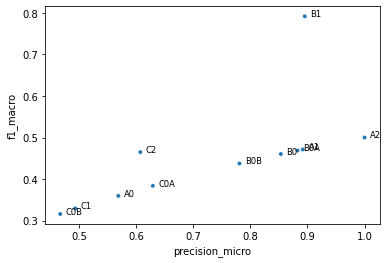

In [203]:
scatter_text("precision_micro", "f1_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='recall_macro', ylabel='recall_micro'>

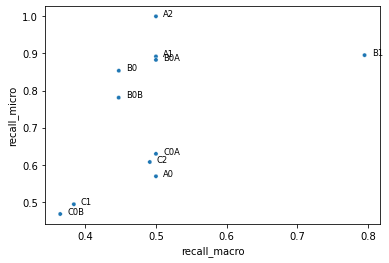

In [204]:
scatter_text("recall_macro", "recall_micro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_macro', ylabel='f1_macro'>

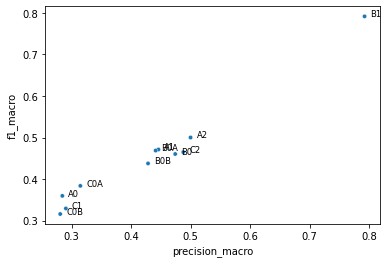

In [205]:
scatter_text("precision_macro", "f1_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_macro', ylabel='recall_macro'>

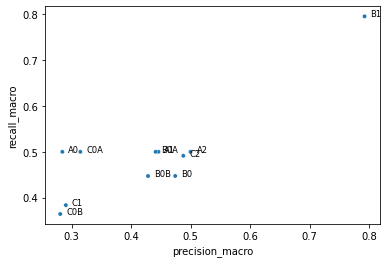

In [206]:
scatter_text("precision_macro", "recall_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_micro', ylabel='recall_micro'>

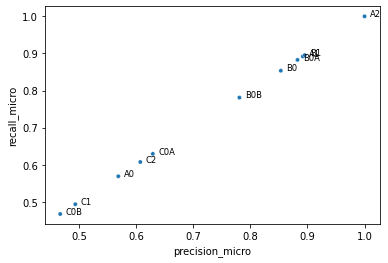

In [207]:
scatter_text("precision_micro", "recall_micro", "level", dataset_mean, "title", "recall", "positive rate")


In [208]:
metrics_names = []
metric = []
beta = []
average = []

experiments = pd.DataFrame.from_dict({"name": metrics_names,
                                     "metric": metric,
                                     "beta" : beta,
                                     "average": average
                                    })

In [22]:
metrics_names = ["accuracy", "f1", "precision", "hit rate", "recall"]
metrics_funs = [accuracy, F1, precision, hit_rate, recall]
for (label, metric) in zip(metrics_names, metrics_funs):
    dataset[label] = dataset.apply(lambda row : metric(row), axis=1)

In [23]:
dataset.groupby(by="level").mean()

,accuracy,f1,precision,hit rate,recall
level,,,,,
A,0.650294,0.000000,1.000000,0.000000,0.000000
B,0.879675,0.000000,1.000000,0.000000,0.000000
C,0.800472,0.000000,1.000000,0.000000,0.000000
D,0.882558,0.000000,1.000000,0.000000,0.000000
E,0.907867,0.334926,0.675900,0.324100,0.675900
F,0.700213,0.250248,0.429452,0.570548,0.429452
